## TreeCorr calculation

Calculation of the 2-point correlation function of the LSB Galaxies.

In [29]:
#Import stuff
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams
#import seaborn as sns
rcParams['font.family'] = 'serif'

# Adjust rc parameters to make plots pretty
def plot_pretty(dpi=200, fontsize=9):
    
    import matplotlib.pyplot as plt

    plt.rc("savefig", dpi=dpi)       # dpi resolution of saved image files
    # if you have LaTeX installed on your laptop, uncomment the line below for prettier labels
    plt.rc('text', usetex=True)      # use LaTeX to process labels
    plt.rc('font', size=fontsize)    # fontsize
    plt.rc('xtick', direction='in')  # make axes ticks point inward
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=10) 
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=10) 
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [0.5, 1.1]) # fix dotted lines

    return

plot_pretty()

In [30]:
import treecorr
import healpy as hp
from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord

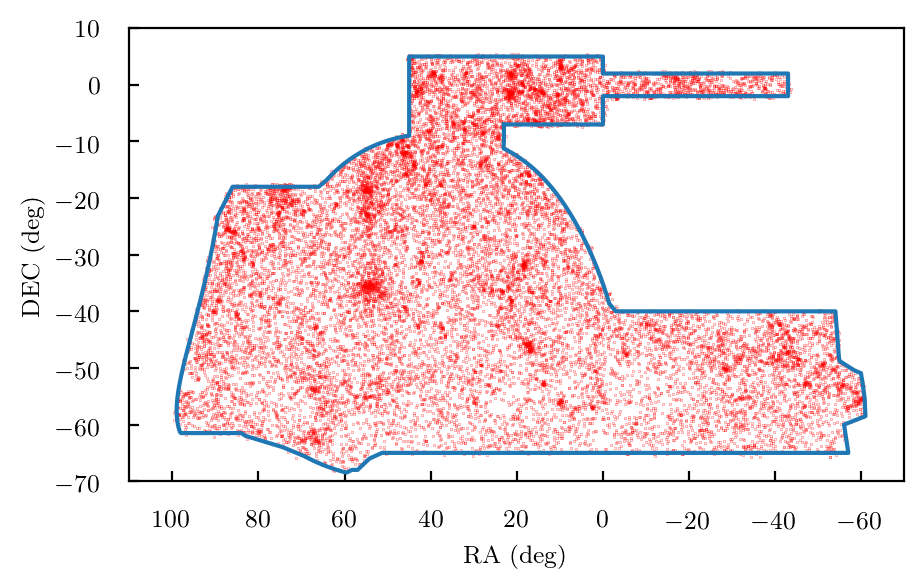

In [31]:
# Import (and plot for visualization reasons) the coordinates of the LSBGs objects
ra_DES, dec_DES = np.loadtxt("DES_polygon.dat", usecols=(0,1), unpack=3)
ra, dec= np.loadtxt("LSBGs_properties.dat", usecols=(1,2), unpack=3)
for i in range(len(ra)):
    if (ra[i] > 150.):
        ra[i] = ra[i]-360.
        
plt.figure(figsize = (5.0,3.0))        
plt.plot(ra_DES, dec_DES)
plt.scatter(ra, dec, c='r', s=0.01)


plt.xlim(110,-70)
plt.ylim(-70,10)
plt.xlabel('RA (deg)');plt.ylabel('DEC (deg)')
plt.show()

In [32]:
# Create catalog
cat = treecorr.Catalog(ra=ra, dec=dec, ra_units='deg', dec_units='deg')

In [33]:
dd = treecorr.NNCorrelation(min_sep=0.01, max_sep=20, bin_size=0.2, sep_units='degrees')
dd.process(cat)

### Create a random catalog

Create a random catalog that covers the footprint.

In [34]:
conv = np.pi/180.
ra_min = -70.0*conv
ra_max = 110.*conv
dec_min = -70.*conv
dec_max = 10.*conv
# ========================
# ========================
rand_ra = np.random.uniform(ra_min, ra_max, 2*10**5)
rand_sindec = np.random.uniform(np.sin(dec_min), np.sin(dec_max), 2*10**5)
rand_dec = np.arcsin(rand_sindec)

#### Create a mask now

In [35]:
MAP = hp.read_map('y3a2_footprint_grizY_any.fits')

NSIDE = 4096
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


In [36]:
# Get a mask - 1 inside the DES mask
DES_mask = np.zeros(len(MAP))
DES_mask[MAP>0] = 1 

In [37]:
# Get the healpix indices of the randoms
HP_ind = hp.ang2pix(4096, rand_ra/conv, rand_dec/conv, lonlat=True)

In [38]:
# Keep only those with randoms for which the value of the des mask 
# ===============================================
# ===============================================
# Keep local mask
LOCAL_mask = DES_mask[HP_ind]

# Keep those with LOCAL_mask = 1
rand_ra_pos = rand_ra[LOCAL_mask==1]
rand_dec_pos = rand_dec[LOCAL_mask==1]

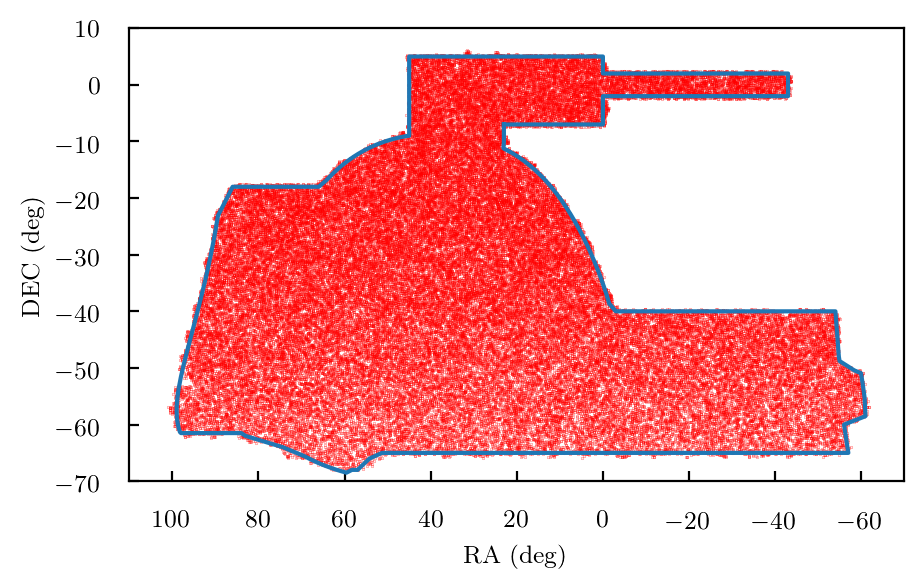

In [39]:
# Let's plot the randoms to see
plt.figure(figsize = (5.0,3.0))
plt.plot(ra_DES, dec_DES)
plt.scatter(rand_ra_pos/conv, rand_dec_pos/conv, c='r', s=0.01)

plt.xlim(110,-70)
plt.ylim(-70,10)
plt.xlabel('RA (deg)');plt.ylabel('DEC (deg)')
plt.show()


Nice! Let's make now a catalog for the randoms

In [40]:
rand = treecorr.Catalog(ra=rand_ra_pos, dec=rand_dec_pos, ra_units='radians', dec_units='radians')
rr = treecorr.NNCorrelation(min_sep=0.01, max_sep=20, bin_size=0.2, sep_units='degrees')
rr.process(rand)

In [41]:
dr = treecorr.NNCorrelation(min_sep=0.01, max_sep=20, bin_size=0.2, sep_units='degrees')
dr.process(cat, rand)

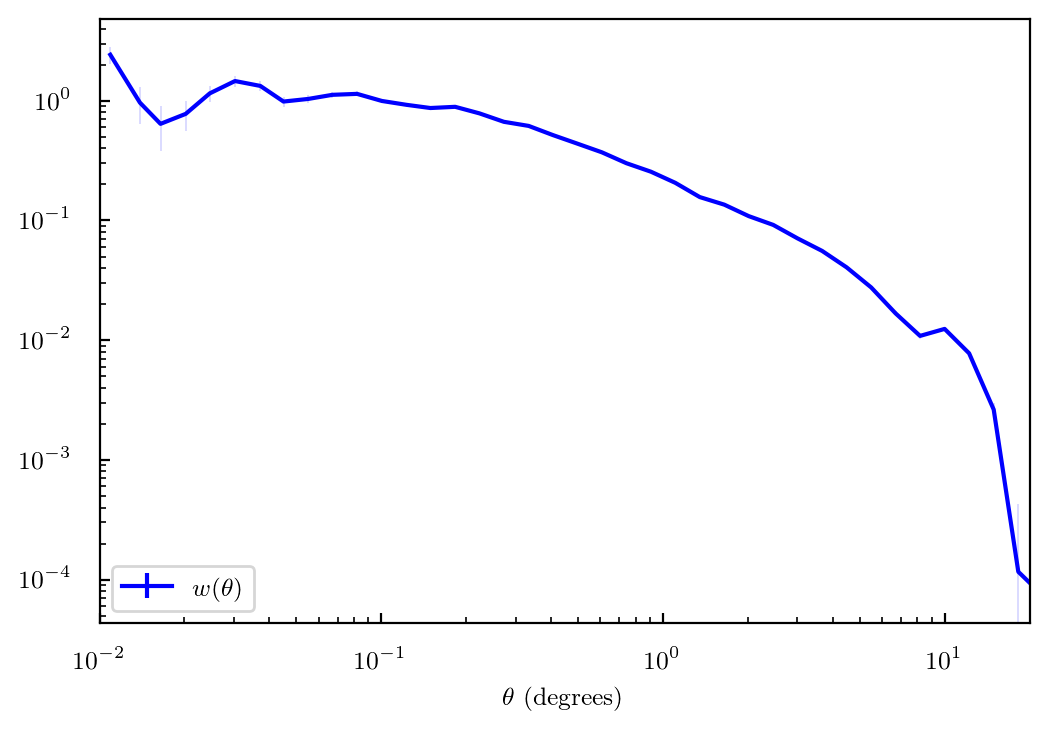

In [42]:
xi, varxi = dd.calculateXi(rr, dr)
r = np.exp(dd.meanlogr)
sig = np.sqrt(varxi)

plt.plot(r, xi, color='blue')
plt.plot(r, -xi, color='blue', ls=':')
plt.errorbar(r[xi>0], xi[xi>0], yerr=sig[xi>0], color='blue', lw=0.1, ls='')
plt.errorbar(r[xi<0], -xi[xi<0], yerr=sig[xi<0], color='blue', lw=0.1, ls='')
leg = plt.errorbar(-r, xi, yerr=sig, color='blue')

plt.xscale('log')
plt.yscale('log', nonposy='clip')
plt.xlabel(r'$\theta$ (degrees)')

plt.legend([leg], [r'$w(\theta)$'], loc='lower left')
plt.xlim([0.01,20])
plt.show()

### Cross correlation with the Abell clusters

In [77]:
# Import the Abell catalog
Abell_cat = fits.open('Abell.fits')
# ================================================
# ================================================
name_Abell = Abell_cat[1].data['NAME']
ra_Abell = Abell_cat[1].data['RA']
dec_Abell = Abell_cat[1].data['DEC']
z_Abell = Abell_cat[1].data['REDSHIFT']
# ================================================
# ================================================
# Keep only those with a redshift less than 0.2
ra_Abell = ra_Abell[z_Abell<0.2]
dec_Abell = dec_Abell[z_Abell<0.2]
name_Abell = name_Abell[z_Abell<0.2]
z_Abell = z_Abell[z_Abell<0.2]

# ================================================
# ================================================
for i in range(len(ra_Abell)):
    if (ra_Abell[i] > 180.):
        ra_Abell[i] = ra_Abell[i]-360.

In [78]:
# Create catalog for the LSB galaxies and the Abell clusters
cat_LSB = treecorr.Catalog(ra=ra, dec=dec, ra_units='deg', dec_units='deg') # Catalog for the LSB galaxies
cat_Abell = treecorr.Catalog(ra=ra_Abell, dec=dec_Abell, ra_units='deg', dec_units='deg') # Catalog for the Abell clusters

In [79]:
# Process them - Create DD (data-data object)
DD = treecorr.NNCorrelation(min_sep=0.01, max_sep=20, bin_size=0.2, sep_units='degrees')
DD.process(cat_LSB,cat_Abell)

##### Create a random catalog for the clusters

We have created a random catalog for the LSB galaxies. Let's now create  random catalog for the galaxy clusters.

In [80]:
# ======================================
rand_ra_Abell = np.random.uniform(ra_min, ra_max, 2*10**5)
rand_sindec_Abell = np.random.uniform(np.sin(dec_min), np.sin(dec_max), 2*10**5)
rand_dec_Abell = np.arcsin(rand_sindec_Abell)
# ======================================
# ======================================
# Get the healpix indices of the randoms
HP_ind_Abell = hp.ang2pix(4096, rand_ra_Abell/conv, rand_dec_Abell/conv, lonlat=True)

In [81]:
# Keep only those with randoms for which the value of the des mask 
# ===============================================
# ===============================================
# Keep local mask
LOCAL_mask_Abell = DES_mask[HP_ind_Abell]

# Keep those with LOCAL_mask = 1
rand_ra_pos_Abell = rand_ra_Abell[LOCAL_mask_Abell==1]
rand_dec_pos_Abell = rand_dec_Abell[LOCAL_mask_Abell==1]

In [82]:
# Create the random catalogs
rand_LSB = treecorr.Catalog(ra=rand_ra_pos, dec=rand_dec_pos, ra_units='radians', dec_units='radians')
rand_Abell = treecorr.Catalog(ra=rand_ra_pos_Abell, dec=rand_dec_pos_Abell, ra_units='radians', dec_units='radians')

In [83]:
# Process them 
RR = treecorr.NNCorrelation(min_sep=0.01, max_sep=20, bin_size=0.2, sep_units='degrees')
RR.process(rand_LSB, rand_Abell)

# Create the RD and DR (cross catalogs)
# ===============================================================
# ===============================================================
# random - data 
RD = treecorr.NNCorrelation(min_sep=0.01, max_sep=20, bin_size=0.2, sep_units='degrees')
RD.process(cat_LSB, rand_Abell)

# data - random
DR = treecorr.NNCorrelation(min_sep=0.01, max_sep=20, bin_size=0.2, sep_units='degrees')
DR.process(cat_Abell, rand_LSB)

In [84]:
xi, varxi = DD.calculateXi(RR, DR, RD)

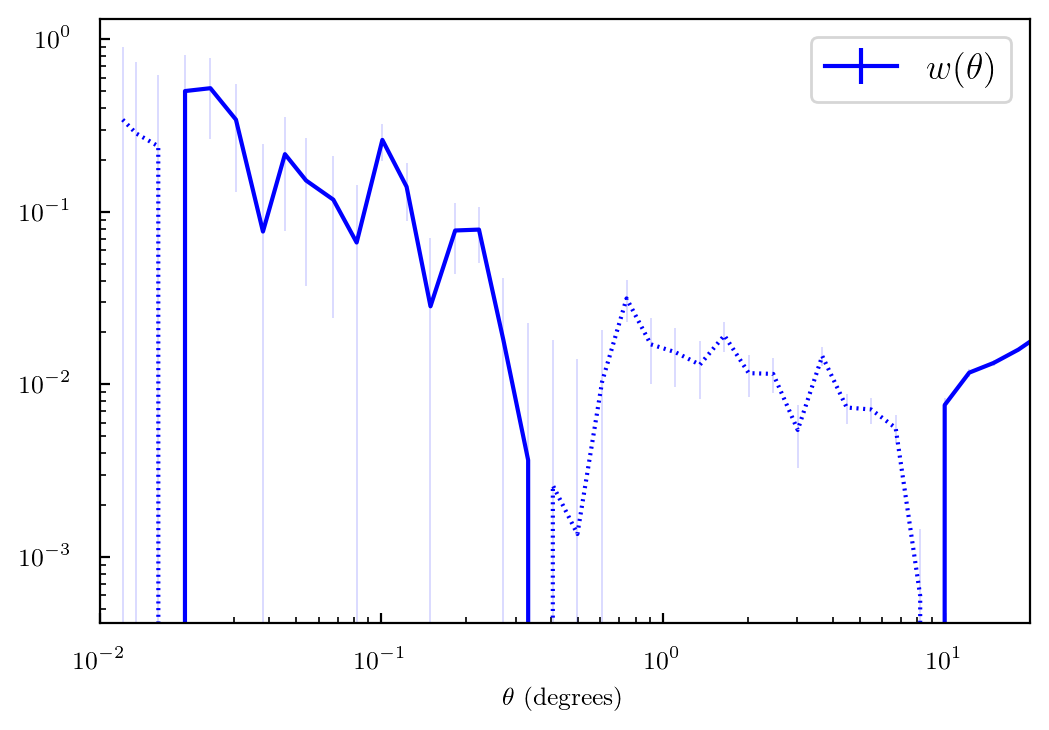

In [85]:
r = np.exp( DD.meanlogr)
sig = np.sqrt(varxi)

plt.plot(r, xi, color='blue')
plt.plot(r, -xi, color='blue', ls=':')
plt.errorbar(r[xi>0], xi[xi>0], yerr=sig[xi>0], color='blue', lw=0.1, ls='')
plt.errorbar(r[xi<0], -xi[xi<0], yerr=sig[xi<0], color='blue', lw=0.1, ls='')
leg = plt.errorbar(-r, xi, yerr=sig, color='blue')

plt.xscale('log')
plt.yscale('log', nonposy='clip')
plt.xlabel(r'$\theta$ (degrees)')

plt.legend([leg], [r'$w(\theta)$'], loc='upper right', fontsize=13)
plt.xlim([0.01,20])
plt.show()